In [1]:
from data_generator import *
import pandas as pd
from ast import literal_eval

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from NN_helpers import *
import matplotlib.pyplot as plt


In [3]:
test_map ="""wwwwwwwwwwwweeewwwwwwwwwww
w  s b    w     w b   b  w
w         w     w        w
w         w     w        w
w         w     w        w
w         w              w
w                        w
w2              w        w
w         wb    w      s w
wwwwwww  wwb    wwwwwwwwww
w s b     wb           b w
w         wb           b w
w         wb   ww        w
w         wb   ww        w
w         w    wwwww wwwww
wwwwwwwwwww    ww3    b  w
e              ww        w
e              ww        e
e                        w
e                        w
wwwwwwwwwww    www  wwwwww
ws b   b  w    wb      b w
w         w    w       b w
w         w    w       b w
w         w    w         w
w         w    w         w
www  wwwwww    wwwwww  www
w               b wb   b w
w                 w      w
w     b   w       w      w
w1        wr      w      w
w         w       w     sw
wwwwwwwwwwwwweeewwwwwwwwww"""

In [4]:
data, G, obj_dir = generate(test_map, 20)
data['run'] = 0
for i in range(1,10):
    d2, G, obj_dir = generate(test_map, 20)
    d2['run'] = i
    data = data.append(d2,ignore_index=True)

In [5]:
i

9

In [59]:
data, G, obj_dir = generate(test_map, 20)
data['run'] = 0

In [60]:
data = data.sort_values(['run','agent','time'])

In [61]:
data = data.reset_index()

In [62]:
data_linear = data.copy()
data_linear['true_agent_loc'] = data_linear['agent_loc']
data_linear['predict_loc'] = [(0,0)]*len(data_linear)
data_linear['prediction'] = [[0,0,0,0,0]]*len(data_linear)
for idx in data_linear.index:
    if data_linear.at[idx, 'time'] > 1:
        data_linear.at[idx, 'prediction'] = data_linear.at[idx-1, 'direction']
data_linear = data_linear.drop(list(data_linear[data_linear.time<2].index))

In [63]:
for i in range(data.shape[0]):
    if data.loc[i]['time'] > 5:
        data.loc[i,'sample1'] = data.loc[i-1]['query_state']
        data.loc[i,'sample2'] = data.loc[i-2]['query_state'] 
        data.loc[i,'sample3'] = data.loc[i-3]['query_state'] 
        data.loc[i,'sample4'] = data.loc[i-4]['query_state']
        data.loc[i,'sample5'] = data.loc[i-5]['query_state']

        
data = data.dropna()
data['predict_loc'] = [(0,0)]*len(data)
data['true_agent_loc'] = data['agent_loc']

In [64]:
#data.target = data.direction.apply(literal_eval)
data.sample1 = data.sample1.fillna('[]').apply(literal_eval)
data.sample2 = data.sample2.fillna('[]').apply(literal_eval)
data.sample3 = data.sample3.fillna('[]').apply(literal_eval)
data.sample4 = data.sample4.fillna('[]').apply(literal_eval)
data.sample5 = data.sample5.fillna('[]').apply(literal_eval)
data.query_state = data.fillna('[]').query_state.apply(literal_eval)

In [65]:
model = Net()
model.load_state_dict(torch.load('network2'))
model.eval()

Net(
  (conv_1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (l_sample): Linear(in_features=200, out_features=121, bias=True)
  (conv_2): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (batch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=400, out_features=100, bias=True)
  (l_out): Linear(in_features=100, out_features=5, bias=False)
)

In [66]:
def predict_linear(data):
    for idx in data.index:
        data.at[idx,'predict_loc'] = pred_to_action(data.at[idx,'prediction'].index(1),data.at[idx,'agent_loc'])
        data.at[idx,'accuracy'] = data.at[idx,'prediction']==data.at[idx,'direction']
        data.at[idx,'pos_acc'] = data.at[idx,'agent_loc']==data.at[idx,'true_agent_loc']
        if euclidean_dist(data.at[idx,'agent_loc'], data.at[idx,'true_agent_loc']) < 3:
            data.at[idx,'pos_acc_2'] = 1
        else:
            data.at[idx,'pos_acc_2'] = 0
    return data

In [67]:
def linear_data(data):
    data_2 = data.copy()
    min_time = min(data.time)
    for idx in data.index:
        if data_2.at[idx, 'time'] > min_time:
            data_2.at[idx,'prediction'] = data.at[idx-1,'prediction']
            data_2.at[idx,'agent_loc'] = data.at[idx-1,'predict_loc']
    data_2 = data_2.drop(list(data_2[data_2.time==min_time].index))
    return data_2

In [68]:
euclidean_dist((0,0),(2,2))

2.8284271247461903

In [69]:
from heuristics import *

In [70]:
acc = []
acc_2 = []
acc_linear = []
acc_linear_2 = []
for i in range(0,16):
    #make predictions
    data = predict_data(data, model)
    data_linear = predict_linear(data_linear)
    #evaluate predictions
    print('Prediction for time step ' + str(i))
    print(data.shape)
    print(sum(data.accuracy == 1)/(sum(data.accuracy==0)+sum(data.accuracy == 1)))
    print(sum(data.pos_acc == 1)/(sum(data.pos_acc==0)+sum(data.pos_acc == 1)))
    print(sum((data.pos_acc == 1) & (data.accuracy == 1))/data.shape[0])
    print(sum((data.pos_acc == 1) & (data.accuracy == 1))/sum(data.pos_acc == 1))
    print(sum(data.pos_acc_2 == 1)/(sum(data.pos_acc_2==0)+sum(data.pos_acc_2 == 1)))
    acc.append(sum((data.pos_acc == 1) & (data.accuracy == 1))/data.shape[0])
    acc_2.append(sum(data.pos_acc_2 == 1)/(sum(data.pos_acc_2==0)+sum(data.pos_acc_2 == 1)))
    
    
    #evaluate linear predictions
    print('Prediction for time step ' + str(i))
    print(data_linear.shape)
    print(sum(data_linear.accuracy == 1)/(sum(data_linear.accuracy==0)+sum(data_linear.accuracy == 1)))
    print(sum(data_linear.pos_acc == 1)/(sum(data_linear.pos_acc==0)+sum(data_linear.pos_acc == 1)))
    print(sum((data_linear.pos_acc == 1) & (data_linear.accuracy == 1))/data_linear.shape[0])
    acc_linear.append(sum((data_linear.pos_acc == 1) & (data_linear.accuracy == 1))/data_linear.shape[0])
    print(sum(data_linear.pos_acc_2 == 1)/(sum(data_linear.pos_acc_2==0)+sum(data_linear.pos_acc_2 == 1)))
    acc_linear_2.append(sum(data_linear.pos_acc_2 == 1)/(sum(data_linear.pos_acc_2==0)+sum(data_linear.pos_acc_2 == 1)))
    
    #make data ready for new predictions
    data = data_from_prediction(data, G, obj_dir)
    data_linear = linear_data(data_linear)

Prediction for time step 0
(634, 19)
0.9400630914826499
1.0
0.9400630914826499
0.9400630914826499
1.0
Prediction for time step 0
(730, 14)
0.7438356164383562
1.0
0.7438356164383562
1.0
Prediction for time step 1
(610, 19)
0.9065573770491804
0.9393442622950819
0.8852459016393442
0.9424083769633508
1.0
Prediction for time step 1
(706, 14)
0.7478753541076487
0.7492917847025495
0.6274787535410765
1.0
Prediction for time step 2
(586, 19)
0.8686006825938567
0.8959044368600683
0.8361774744027304
0.9333333333333333
0.9880546075085325
Prediction for time step 2
(682, 14)
0.7126099706744868
0.6348973607038123
0.533724340175953
0.9926686217008798
Prediction for time step 3
(562, 19)
0.8327402135231317
0.8487544483985765
0.7882562277580071
0.9287211740041929
0.9661921708185054
Prediction for time step 3
(658, 14)
0.6793313069908815
0.5379939209726444
0.44376899696048633
0.8844984802431611
Prediction for time step 4
(538, 19)
0.8048327137546468
0.8122676579925651
0.7527881040892194
0.92677345537757

In [37]:
data.loc[20].sample1[0] == data.loc[20].sample2[0]

False

In [108]:
4**25

1125899906842624

In [27]:
sum(([item in data_all_correct for item in data.index]) & (data.accuracy==1))

636

In [78]:
data_test = pd.read_csv('test_new.csv')

In [79]:
#data_test = data_test[data_test.run==2]
#data.target = data.direction.apply(literal_eval)
data_test.sample1 = data_test.sample1.fillna('[]').apply(literal_eval)
data_test.sample2 = data_test.sample2.fillna('[]').apply(literal_eval)
data_test.sample3 = data_test.sample3.fillna('[]').apply(literal_eval)
data_test.sample4 = data_test.sample4.fillna('[]').apply(literal_eval)
data_test.sample5 = data_test.sample5.fillna('[]').apply(literal_eval)
data_test.query_state = data_test.query_state.fillna('[]').apply(literal_eval)
data_test.direction = data_test.direction.fillna('[]').apply(literal_eval)
data_test.agent_loc = data_test.agent_loc.fillna('[]').apply(literal_eval)

data_test['predict_loc'] = [(0,0)]*len(data_test)
data_test['true_agent_loc'] = data_test['agent_loc']

In [80]:
data_tes_preds = predict_data(data_test, model)

In [81]:
sum(data_tes_preds.accuracy==1)/data_tes_preds.shape[0]

0.9311283712132068

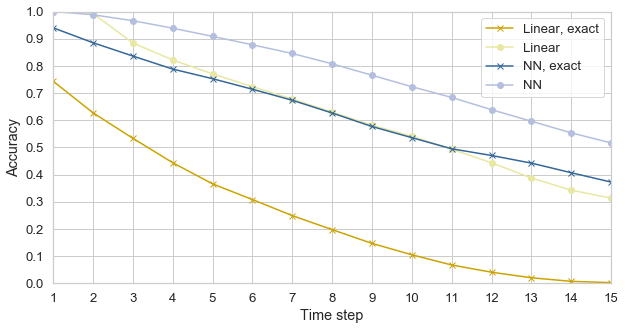

In [90]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=(10,5))

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],acc_linear[:-1], '-x',label='Linear, exact', color='#CCA300')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],acc_linear_2[1:], '-o',label='Linear', color='#E8E8A3')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], acc[:-1],'-x',label='NN, exact', color='#336699')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],acc_2[1:], '-o',label='NN', color='#B4BFE0')
plt.xlabel('Time step')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.xlim((1,15))
plt.xticks(np.arange(1, 15+1, 1.0))
plt.yticks(np.arange(0, 1+0.05, 0.1))
plt.legend()

In [91]:
fig.savefig('performance.png')

In [25]:
G[(14-4,9+2)]

KeyError: (10, 11)

In [29]:
data.loc[41]['query_state']

[[(-5, 0),
  (-4, -5),
  (-4, -4),
  (-4, -1),
  (-4, 0),
  (-4, 1),
  (-4, 2),
  (-4, 3),
  (-4, 4),
  (-4, 5),
  (1, 3),
  (1, 4),
  (1, 5),
  (2, -5),
  (2, -2),
  (2, -1),
  (2, 0),
  (2, 3),
  (2, 4),
  (2, 5),
  (3, 0),
  (3, 5),
  (4, 0),
  (4, 5),
  (5, 0),
  (5, 5)],
 [(-3, -1),
  (-3, 0),
  (-3, 1),
  (-3, 3),
  (-3, 4),
  (-3, 5),
  (-2, -1),
  (-2, 0),
  (-2, 1),
  (-2, 3),
  (-2, 4),
  (-2, 5)],
 [(0, 0)],
 [0, 0, 0, 0, 0]]

In [26]:
data[data.pos_acc==1]

,index,agent,direction,time,true_time,agent_loc,query_state,run,sample1,sample2,sample3,sample4,sample5,predict_loc,true_agent_loc,accuracy,prediction,pos_acc
40,212,0,"[1, 0, 0, 0, 0]",41,41,"(5, 17)","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...",0,"[[(-5, -2), (-5, 3), (-4, -2), (-4, 3), (-3, -...","[[(-5, -2), (-5, 3), (-4, -2), (-4, 3), (-3, -...","[[(-5, -2), (-5, 3), (-4, -2), (-4, 3), (-3, -...","[[(-5, -2), (-5, 3), (-4, -2), (-4, 3), (-3, -...","[[(-5, -2), (-5, 3), (-4, -2), (-4, 3), (-3, -...","(14, 9)","(14, 10)",1.0,0.0,1.0
41,216,0,"[1, 0, 0, 0, 0]",42,42,"(14, 9)","[[(-5, 0), (-4, -5), (-4, -4), (-4, -1), (-4, ...",0,"[[(-5, -1), (-5, 5), (-4, -5), (-4, -2), (-4, ...","[[(-5, 5), (-4, -1), (-4, 5), (-3, -5), (-3, -...","[[(-5, 4), (-4, -2), (-4, 4), (-3, -3), (-3, -...","[[(-5, 3), (-4, -3), (-4, 3), (-3, -4), (-3, -...","[[(-5, 2), (-4, -4), (-4, 2), (-3, -5), (-3, -...","(14, 8)","(14, 9)",1.0,0.0,1.0
42,220,0,"[1, 0, 0, 0, 0]",43,43,"(14, 8)","[[(-5, 1), (-4, -5), (-4, -4), (-4, -3), (-4, ...",0,"[[(-5, 0), (-4, -5), (-4, -4), (-4, -1), (-4, ...","[[(-5, -1), (-5, 5), (-4, -5), (-4, -2), (-4, ...","[[(-5, 5), (-4, -1), (-4, 5), (-3, -5), (-3, -...","[[(-5, 4), (-4, -2), (-4, 4), (-3, -3), (-3, -...","[[(-5, 3), (-4, -3), (-4, 3), (-3, -4), (-3, -...","(14, 7)","(14, 8)",1.0,0.0,1.0
43,225,0,"[1, 0, 0, 0, 0]",44,44,"(14, 7)","[[(-5, 2), (-4, -5), (-4, -4), (-4, -3), (-4, ...",0,"[[(-5, 1), (-4, -5), (-4, -4), (-4, -3), (-4, ...","[[(-5, 0), (-4, -5), (-4, -4), (-4, -1), (-4, ...","[[(-5, -1), (-5, 5), (-4, -5), (-4, -2), (-4, ...","[[(-5, 5), (-4, -1), (-4, 5), (-3, -5), (-3, -...","[[(-5, 4), (-4, -2), (-4, 4), (-3, -3), (-3, -...","(14, 6)","(14, 7)",1.0,0.0,1.0
44,230,0,"[1, 0, 0, 0, 0]",45,45,"(14, 6)","[[(-5, 3), (-4, -5), (-4, -4), (-4, -3), (-4, ...",0,"[[(-5, 2), (-4, -5), (-4, -4), (-4, -3), (-4, ...","[[(-5, 1), (-4, -5), (-4, -4), (-4, -3), (-4, ...","[[(-5, 0), (-4, -5), (-4, -4), (-4, -1), (-4, ...","[[(-5, -1), (-5, 5), (-4, -5), (-4, -2), (-4, ...","[[(-5, 5), (-4, -1), (-4, 5), (-3, -5), (-3, -...","(14, 5)","(14, 6)",1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,847,24,"[1, 0, 0, 0, 0]",18,162,"(13, 14)","[[(-5, 1), (-4, -5), (-4, 1), (-3, -5), (-3, -...",0,"[[(-5, 0), (-5, 5), (-4, 0), (-4, 5), (-3, -5)...","[[(-5, -1), (-5, 4), (-4, -1), (-4, 4), (-3, -...","[[(-5, -2), (-5, 3), (-4, -2), (-4, 3), (-3, -...","[[(-5, -3), (-5, 2), (-4, -3), (-4, 2), (-3, -...","[[(-5, -3), (-5, 2), (-4, -3), (-4, 2), (-3, -...","(13, 13)","(13, 14)",1.0,0.0,1.0
855,850,24,"[1, 0, 0, 0, 0]",19,163,"(13, 13)","[[(-5, 2), (-4, -4), (-4, 2), (-3, -5), (-3, -...",0,"[[(-5, 1), (-4, -5), (-4, 1), (-3, -5), (-3, -...","[[(-5, 0), (-5, 5), (-4, 0), (-4, 5), (-3, -5)...","[[(-5, -1), (-5, 4), (-4, -1), (-4, 4), (-3, -...","[[(-5, -2), (-5, 3), (-4, -2), (-4, 3), (-3, -...","[[(-5, -3), (-5, 2), (-4, -3), (-4, 2), (-3, -...","(13, 12)","(13, 13)",1.0,0.0,1.0
856,853,24,"[1, 0, 0, 0, 0]",20,164,"(13, 12)","[[(-5, 3), (-4, -3), (-4, 3), (-3, -4), (-3, -...",0,"[[(-5, 2), (-4, -4), (-4, 2), (-3, -5), (-3, -...","[[(-5, 1), (-4, -5), (-4, 1), (-3, -5), (-3, -...","[[(-5, 0), (-5, 5), (-4, 0), (-4, 5), (-3, -5)...","[[(-5, -1), (-5, 4), (-4, -1), (-4, 4), (-3, -...","[[(-5, -2), (-5, 3), (-4, -2), (-4, 3), (-3, -...","(13, 11)","(13, 12)",1.0,0.0,1.0
857,856,24,"[1, 0, 0, 0, 0]",21,165,"(13, 11)","[[(-5, 4), (-4, -2), (-4, 4), (-3, -3), (-3, -...",0,"[[(-5, 3), (-4, -3), (-4, 3), (-3, -4), (-3, -...","[[(-5, 2), (-4, -4), (-4, 2), (-3, -5), (-3, -...","[[(-5, 1), (-4, -5), (-4, 1), (-3, -5), (-3, -...","[[(-5, 0), (-5, 5), (-4, 0), (-4, 5), (-3, -5)...","[[(-5, -1), (-5, 4), (-4, -1), (-4, 4), (-3, -...","(13, 10)","(13, 11)",1.0,0.0,1.0


In [455]:
data_0 = data[data.agent==0].copy()

In [456]:
data_0 = data_0.drop(['index','agent','true_time','run','predict_loc'],axis=1)

In [457]:
data_0 = data_0.loc[5:5].reset_index()
data_0['Probs'] = 1

In [458]:
data_0

,index,direction,time,agent_loc,query_state,sample1,sample2,sample3,sample4,sample5,true_agent_loc,accuracy,prediction,pos_acc,Probs
0,5,"[0, 1, 0, 0, 0]",6,"(3, 24)","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","(3, 24)",1.0,1.0,1.0,1


In [459]:
s = torch.nn.Softmax(dim=1)

pred = model(transform(data_0, 0))['out']

probs = s(pred)
probs = probs.data.numpy()
probs=probs[0]
probs

array([9.350007e-05, 9.472483e-01, 2.137309e-03, 4.987983e-02,
       6.410707e-04], dtype=float32)

In [460]:
d = {}
for i in range(0,5):
    data_part = pd.DataFrame(columns=data_0.columns)
    for j in range(len(data_0)):
        print(j)
        s = torch.nn.Softmax(dim=1)

        pred = model(transform(data_0, j))['out']

        probs = s(pred)
        probs = probs.data.numpy()
        probs=probs[0]
        data_p = data_from_prediction(data_0, G, obj_dir, j)
        print(data_p.shape)
        data_p.loc[:,'Probs'] = list(data_0.loc[j,'Probs']*probs)
        data_p.loc[:,'index'] = j
        data_part = pd.concat([data_part, data_p])
        print(data_part.shape)
    data_part = data_part.reset_index(drop=True)
    d[i] = data_part.copy()
    data_0 = data_part.copy()

0
0
1
2
3
4
(5, 15)
(5, 15)
0
0
1
2
3
4
(5, 15)
(5, 15)
1
0
1
2
3
4
(5, 15)
(10, 15)
2
0
1
2
3
4
(5, 15)
(15, 15)
3
0
1
2
3
4
(5, 15)
(20, 15)
4
0
1
2
3
4
(5, 15)
(25, 15)
0
0
1
2
3
4
(5, 15)
(5, 15)
1
0
1
2
3
4
(5, 15)
(10, 15)
2
0
1
2
3
4
(5, 15)
(15, 15)
3
0
1
2
3
4
(5, 15)
(20, 15)
4
0
1
2
3
4
(5, 15)
(25, 15)
5
0
1
2
3
4
(5, 15)
(30, 15)
6
0
1
2
3
4
(5, 15)
(35, 15)
7
0
1
2
3
4
(5, 15)
(40, 15)
8
0
1
2
3
4
(5, 15)
(45, 15)
9
0
1
2
3
4
(5, 15)
(50, 15)
10
0
1
2
3
4
(5, 15)
(55, 15)
11
0
1
2
3
4
(5, 15)
(60, 15)
12
0
1
2
3
4
(5, 15)
(65, 15)
13
0
1
2
3
4
(5, 15)
(70, 15)
14
0
1
2
3
4
(5, 15)
(75, 15)
15
0
1
2
3
4
(5, 15)
(80, 15)
16
0
1
2
3
4
(5, 15)
(85, 15)
17
0
1
2
3
4
(5, 15)
(90, 15)
18
0
1
2
3
4
(5, 15)
(95, 15)
19
0
1
2
3
4
(5, 15)
(100, 15)
20
0
1
2
3
4
(5, 15)
(105, 15)
21
0
1
2
3
4
(5, 15)
(110, 15)
22
0
1
2
3
4
(5, 15)
(115, 15)
23
0
1
2
3
4
(5, 15)
(120, 15)
24
0
1
2
3
4
(5, 15)
(125, 15)
0
0
1
2
3
4
(5, 15)
(5, 15)
1
0
1
2
3
4
(5, 15)
(10, 15)
2
0
1
2
3
4
(5, 15)
(15, 1

4
(5, 15)
(1810, 15)
362
0
1
2
3
4
(5, 15)
(1815, 15)
363
0
1
2
3
4
(5, 15)
(1820, 15)
364
0
1
2
3
4
(5, 15)
(1825, 15)
365
0
1
2
3
4
(5, 15)
(1830, 15)
366
0
1
2
3
4
(5, 15)
(1835, 15)
367
0
1
2
3
4
(5, 15)
(1840, 15)
368
0
1
2
3
4
(5, 15)
(1845, 15)
369
0
1
2
3
4
(5, 15)
(1850, 15)
370
0
1
2
3
4
(5, 15)
(1855, 15)
371
0
1
2
3
4
(5, 15)
(1860, 15)
372
0
1
2
3
4
(5, 15)
(1865, 15)
373
0
1
2
3
4
(5, 15)
(1870, 15)
374
0
1
2
3
4
(5, 15)
(1875, 15)
375
0
1
2
3
4
(5, 15)
(1880, 15)
376
0
1
2
3
4
(5, 15)
(1885, 15)
377
0
1
2
3
4
(5, 15)
(1890, 15)
378
0
1
2
3
4
(5, 15)
(1895, 15)
379
0
1
2
3
4
(5, 15)
(1900, 15)
380
0
1
2
3
4
(5, 15)
(1905, 15)
381
0
1
2
3
4
(5, 15)
(1910, 15)
382
0
1
2
3
4
(5, 15)
(1915, 15)
383
0
1
2
3
4
(5, 15)
(1920, 15)
384
0
1
2
3
4
(5, 15)
(1925, 15)
385
0
1
2
3
4
(5, 15)
(1930, 15)
386
0
1
2
3
4
(5, 15)
(1935, 15)
387
0
1
2
3
4
(5, 15)
(1940, 15)
388
0
1
2
3
4
(5, 15)
(1945, 15)
389
0
1
2
3
4
(5, 15)
(1950, 15)
390
0
1
2
3
4
(5, 15)
(1955, 15)
391
0
1
2
3
4
(5, 15)


In [461]:
data1=d[1]

In [453]:
data1[data1.agent_loc==(2,25)]['query_state'][8][0]

[(-5, -5),
 (-5, -4),
 (-5, -3),
 (-5, -2),
 (-5, -1),
 (-5, 0),
 (-5, 1),
 (-5, 2),
 (-5, 3),
 (-5, 4),
 (-5, 5),
 (-4, -5),
 (-4, -4),
 (-4, -3),
 (-4, -2),
 (-4, -1),
 (-4, 0),
 (-4, 1),
 (-4, 2),
 (-4, 3),
 (-4, 4),
 (-4, 5),
 (-3, -5),
 (-3, -4),
 (-3, -3),
 (-3, -2),
 (-3, -1),
 (-3, 0),
 (-3, 1),
 (-3, 2),
 (-3, 3),
 (-3, 4),
 (-3, 5),
 (-2, -5),
 (-2, -4),
 (-2, -3),
 (-2, -2),
 (-2, -1),
 (-2, 0),
 (-2, 1),
 (-2, 2),
 (-2, 3),
 (-2, 4),
 (-2, 5),
 (-1, -5),
 (-1, 1),
 (0, -5),
 (0, 1),
 (1, -5),
 (2, -5),
 (3, -5),
 (3, 1),
 (4, -5),
 (4, 1),
 (5, -5),
 (5, 1)]

In [390]:
groups = data4.groupby('agent_loc', as_index=False).sum()
groups.loc[0, 'agent_loc'][1]

24

In [478]:
data4 = d[4]

In [473]:
groups

,agent_loc,accuracy,prediction,pos_acc,Probs
0,"(-1, 24)",0.0,0.0,0.0,3.173078e-08
1,"(0, 23)",1.0,1.0,1.0,7.373143e-10
2,"(0, 24)",0.0,0.0,0.0,2.246247e-06
3,"(0, 25)",0.0,0.0,0.0,1.797262e-03
4,"(1, 22)",3.0,3.0,3.0,4.272469e-11
5,"(1, 23)",3.0,3.0,3.0,2.153260e-08
6,"(1, 24)",3.0,3.0,3.0,9.618450e-05
7,"(1, 25)",0.0,0.0,0.0,2.772177e-03
8,"(1, 26)",0.0,0.0,0.0,8.213515e-03
9,"(2, 21)",3.0,3.0,3.0,1.114476e-12


In [479]:
prob_map = np.zeros([11,11])
groups = data3.groupby('agent_loc', as_index=False).sum()
for i in range(len(groups)):
    print((groups.loc[i,'agent_loc'][0]+1,groups.loc[i,'agent_loc'][1]-20))
    prob_map[(groups.loc[i,'agent_loc'][1]-18, groups.loc[i,'agent_loc'][0]+3)] = groups.loc[i,'Probs']

(0, 4)
(1, 3)
(1, 4)
(1, 5)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(7, 3)
(7, 4)
(7, 5)
(8, 4)


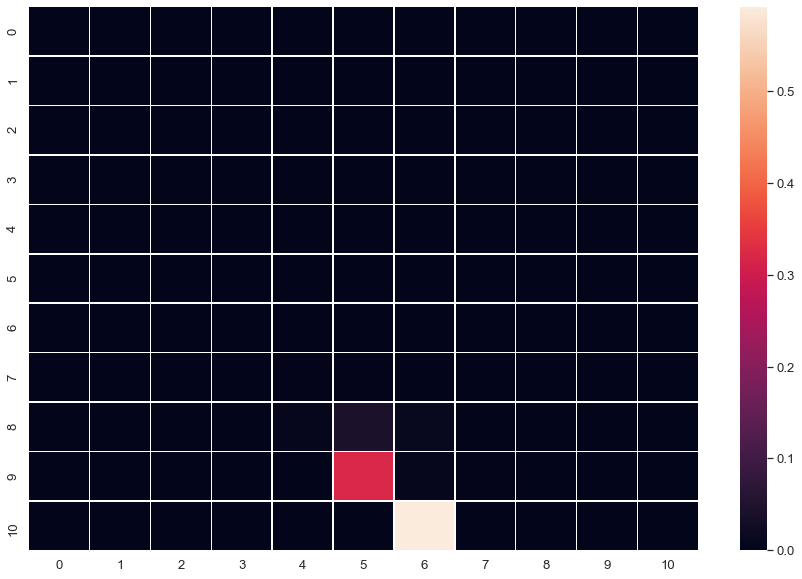

In [480]:
plt.figure(figsize=(15,10))
sns.heatmap(prob_map, linewidth=0.5)

In [399]:
prob_map

array([[0.00000000e+00, 1.67206393e-11, 8.75561206e-09, 1.19183343e-05,
        1.71922578e-03, 5.72939414e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [5.82175450e-13, 6.63222758e-11, 5.73872662e-08, 2.13501729e-05,
        1.90377431e-03, 3.90698111e-03, 6.89890297e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.66002810e-12, 5.83910372e-11, 3.89969518e-08, 7.60255466e-05,
        9.69220254e-04, 5.68185289e-03, 2.24688617e-01, 1.03637272e-01,
        0.00000000e+00, 4.81299003e-14],
       [7.16824920e-13, 1.80308124e-11, 2.20730917e-08, 1.06028331e-05,
        1.01211044e-04, 4.31007496e-04, 6.57622808e-02, 1.61998905e-02,
        7.57659301e-02, 1.57117513e-14],
       [1.18274794e-12, 8.48312868e-11, 6.32549894e-10, 6.78183203e-07,
        3.53906253e-07, 5.60725764e-05, 3.86748602e-05, 4.91249099e-01,
        0.00000000e+00, 1.91009345e-15],
       [7.04090375e-14, 4.17245662e-10, 1.77889402e-08, 2.44086989e-07,
   

In [336]:
def data_from_prediction(data, G, obj_dic, index):
    data_2 = data[0:5].copy()
    min_time = min(data.time)
    for idx in range(0,5):
        print(idx)
        #move states down one position
        data_2.at[idx,'sample1'] = 0
        data_2.at[idx,'sample1'] = data.loc[index,'query_state'] 
        data_2.at[idx,'sample2'] = data.loc[index,'sample1'] 
        data_2.at[idx,'sample3'] = data.loc[index,'sample2'] 
        data_2.at[idx,'sample4'] = data.loc[index,'sample3'] 
        data_2.at[idx,'sample5'] = data.loc[index,'sample4']
        data_2.at[idx,'time'] = data.loc[index,'time'] 
        #replace query state by predicted state
        data_2.at[idx,'query_state'] = new_state(G, pred_to_action(idx, data.loc[index,'agent_loc']),obj_dic)

        direction_vec = [0,0,0,0,0]
        direction_vec[idx] = 1
        data_2.at[idx,'sample1'][-1] = direction_vec
        data_2.at[idx,'agent_loc'] = pred_to_action(idx, data.loc[index,'agent_loc'])
    return data_2

In [454]:
def new_state(G, pred_loc, obj_dic):
    w = []
    o = []
    a = []
    pos = pred_loc
    l = [(x,y) for x in list(range(-5,6)) for y in list(range(-5,6))]
    for loc in l:
        coor = (pos[0]+loc[0],pos[1]+loc[1])
        if coor not in G.nodes:
            w.append(loc)
        elif coor in obj_dic:
            o.append(loc)
    direction_vec = [0,0,0,0,0]
    return [w, o, a, direction_vec]

In [335]:
data[0:5]

,index,agent,direction,time,true_time,agent_loc,query_state,run,sample1,sample2,sample3,sample4,sample5,predict_loc,true_agent_loc
5,25,0,"[0, 1, 0, 0, 0]",6,6,"(3, 24)","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...",0,"[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","(0, 0)","(3, 24)"
6,30,0,"[0, 1, 0, 0, 0]",7,7,"(3, 25)","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...",0,"[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","(0, 0)","(3, 25)"
7,35,0,"[0, 1, 0, 0, 0]",8,8,"(3, 26)","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...",0,"[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","(0, 0)","(3, 26)"
8,40,0,"[0, 1, 0, 0, 0]",9,9,"(3, 27)","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...",0,"[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","(0, 0)","(3, 27)"
9,45,0,"[0, 1, 0, 0, 0]",10,10,"(3, 28)","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...",0,"[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","(0, 0)","(3, 28)"


In [182]:
data_first.loc[:,'Probs'] = list(probs[0])

In [185]:
list(np.array(data_first.loc[:,'Probs'])*np.array(list(probs[0])))

[1.7028196717419254e-07,
 0.6870503744334009,
 0.00113714251952729,
 0.00598647590161866,
 0.0035531684407033026]

In [183]:
data_first.loc[:,'Probs']

0    0.000413
1    0.828885
2    0.033722
3    0.077372
4    0.059608
Name: Probs, dtype: float64

In [137]:
data_0

,index,direction,time,agent_loc,query_state,sample1,sample2,sample3,sample4,sample5,true_agent_loc
0,5.0,"[0, 1, 0, 0, 0]",6,"(3, 24)","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...","(3, 24)"
1,NaN,"[0, 0, 0, 0, 0]",NaN,NaN,"[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...",NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,"[[(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5,...",NaN,NaN,NaN,NaN,NaN,NaN
